In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 15))
train_y = Variable(torch.sign(torch.cos(train_x.data * (2 * math.pi))))

In [5]:
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch import ObservationModel
from gpytorch.random_variables import GaussianRandomVariable
from gpytorch.parameters import MLEParameterGroup
from torch.nn import Parameter

In [6]:
class GPClassificationModel(gpytorch.ObservationModel):
    def __init__(self):
        super(GPClassificationModel,self).__init__(BernoulliLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel()
        self.params = MLEParameterGroup(
            log_lengthscale=Parameter(torch.Tensor([math.log(0.1)])),
            log_outputscale=Parameter(torch.Tensor([-1])),
        )
    
    def forward(self,x):
        mean_x = self.mean_module(x, constant=Variable(torch.Tensor([0])))
        covar_x = self.covar_module(x, log_lengthscale=self.params.log_lengthscale)
        covar_x = covar_x.mul(self.params.log_outputscale.exp().expand_as(covar_x))
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

prior_observation_model = GPClassificationModel()

In [7]:
def plot_model_and_predictions(observation_model):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 51))
    observed_pred = observation_model(test_x)

    def ax_plot(ax, rand_var, title):
        pred_probs = rand_var.mean()
        pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
        ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), pred_labels.data.numpy(), 'b')
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

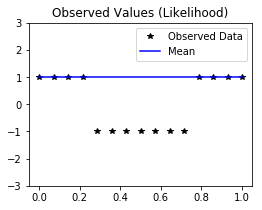

In [8]:
f = plot_model_and_predictions(prior_observation_model)

In [9]:
from gpytorch.inference import Inference
import cProfile

def log_function(loss, optimizer, observation_model):
    return 'Iter: %02d, Loss: %.3f' % (optimizer.n_iter, loss.data[0])

infer = Inference(prior_observation_model)
posterior_observation_model = infer.run(train_x, train_y,max_inference_steps=100)

0 -271536.65625
1 -23.861825943
2 -19.8542804718
3 -13.150727272
4 -15.6247816086
5 -13.7857170105
6 -16.216632843
7 -14.0848150253
8 -13.4510192871
9 -15.5753822327
10 -15.2123718262
11 -14.4286270142
12 -11.5976924896
13 -11.7185020447
14 -13.8002147675
15 -10.1829071045
16 -12.5679283142
17 -11.0259590149
18 -10.6002845764
19 -10.1158227921
20 -10.6840200424
21 -9.71649646759
22 -7.74183559418
23 -10.0202903748
24 -9.44572544098
25 -9.00411987305
26 -8.6178817749
27 -9.87413692474
28 -7.95426416397
29 -10.8339338303
30 -10.0554914474
31 -9.95463371277
32 -11.9867763519
33 -9.74333381653
34 -8.44249248505
35 -8.00511264801
36 -9.98693656921
37 -12.5944690704
38 -7.7828950882
39 -11.280424118
40 -8.8498210907
41 -8.86623954773
42 -7.9329328537
43 -7.94100809097
44 -8.57110595703
45 -8.69177246094
46 -9.5731086731
47 -9.32789039612
48 -8.87726593018
49 -7.43687963486
50 -10.2612638474
51 -8.82627105713
52 -7.76473236084
53 -7.68791246414
54 -9.0815114975
55 -11.1520576477
56 -8.2731418

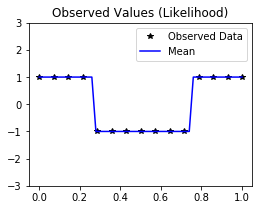

In [12]:
f = plot_model_and_predictions(posterior_observation_model)